In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## GET AVERAGE RETURNS OVER TIME OF THE AVAILABLE FUNDS

In [2]:
# Connection to WRDS
import wrds
db = wrds.Connection(wrds_username='etiennebruno')

Loading library list...
Done


In [3]:
# Import CIKs from the dataframe of all cleaned filings
from utils import *
ciks = ', '.join(list(df_from_filings().cik.unique()))

In [4]:
# Get all cik number available (intersection between our dataframe and the data on CRSP)
ciks_data = db.raw_sql(f'''
        select distinct comp_cik
        from crsp_q_mutualfunds.crsp_cik_map
        where comp_cik in ({ciks})
''')
cik_available = list(ciks_data.comp_cik)

cik_available_crsp_pkl = ['000'+str(int(c)) for c in cik_available]
save_pkl(cik_available_crsp_pkl, 'data/cik_available_crsp.pkl')

cik_available = ', '.join([str(i) for i in cik_available])

In [5]:
# With the mapping table of CRSP, get all companies' fund number
crsp_fundno_available = db.raw_sql(f'''
        select *
        from crsp_q_mutualfunds.crsp_cik_map
        where comp_cik in ({cik_available})
''')
crsp_fundno_available

,crsp_fundno,comp_cik,series_cik,contract_cik
0,5.0,351895.0,S000004050,C000011336
1,357.0,883496.0,None,None
2,743.0,848012.0,S000006084,C000016714
3,3537.0,1311981.0,S000004764,C000012957
4,4456.0,1105877.0,S000005190,C000014168
...,...,...,...,...
181,98751.0,1848758.0,S000071907,None
182,98870.0,1760588.0,S000066608,None
183,99118.0,1508033.0,S000072822,C000229393
184,99243.0,1849998.0,S000074173,None


In [6]:
# Convert the list of fund numbers to a list of string type for future SQL queries
list_float_fundnos = list(crsp_fundno_available.crsp_fundno.unique())
crsp_fundno_available_list_str = ', '.join([str(i) for i in list_float_fundnos])

In [7]:
# Get all available returns for each fund
monthly_returns_all_funds = db.raw_sql(f'''
        select *
        from crsp_q_mutualfunds.monthly_returns
        where crsp_fundno in ({crsp_fundno_available_list_str})
        order by caldt desc
''')
monthly_returns_all_funds

,crsp_fundno,caldt,mret
0,38899.0,2022-03-31,-0.000767
1,8032.0,2022-03-31,0.033234
2,22178.0,2022-03-31,0.013476
3,96948.0,2022-03-31,0.026055
4,6029.0,2022-03-31,0.027255
...,...,...,...
46417,9498.0,1961-12-29,NaN
46418,31946.0,1961-12-29,NaN
46419,22286.0,1961-12-29,NaN
46420,12082.0,1961-12-29,NaN


In [8]:
monthly_returns_all_funds = monthly_returns_all_funds[monthly_returns_all_funds['mret']<4]

In [9]:
monthly_returns_all_funds[monthly_returns_all_funds['mret']>=1]

,crsp_fundno,caldt,mret
15542,93941.0,2012-05-31,1.660611
16700,93941.0,2011-08-31,1.048365
18444,93941.0,2010-05-28,1.611057
20707,93941.0,2008-10-31,1.883233
20863,93941.0,2008-09-30,1.975570
25021,93941.0,2005-06-30,3.666667
30166,93941.0,2000-12-29,1.916404


## GET AVERAGE RETURNS OVER TIME OF THE AVAILABLE FUNDS - GROUPED BY MONTH

In [10]:
# Create a new dataframe with some statistic and the average return
monthly_returns_all_funds_aggregated = monthly_returns_all_funds[['caldt', 'mret']].groupby('caldt').agg(
    count=('mret', 'count'),
    mret=('mret', 'mean'),
    mret_max=('mret', 'max'),
    mret_min=('mret', 'min'),
    mret_sdt=('mret', 'std'),
)

In [11]:
monthly_returns_all_funds_aggregated.reset_index(inplace=True)
monthly_returns_all_funds_aggregated['caldt'] = pd.to_datetime(monthly_returns_all_funds_aggregated['caldt'], format= '%Y-%m-%d')

In [12]:
monthly_returns_all_funds_aggregated = monthly_returns_all_funds_aggregated.loc[monthly_returns_all_funds_aggregated['caldt'] >= '2000-01-01']
monthly_returns_all_funds_aggregated

,caldt,count,mret,mret_max,mret_min,mret_sdt
456,2000-01-31,84,-0.010239,0.128821,-0.080595,0.031930
457,2000-02-29,84,0.027115,0.402302,-0.104092,0.085716
458,2000-03-31,85,0.031616,0.163592,-0.316574,0.060557
459,2000-04-28,85,-0.012203,0.103542,-0.116459,0.034927
460,2000-05-31,85,-0.011158,0.063172,-0.141604,0.036864
...,...,...,...,...,...,...
718,2021-11-30,115,-0.018170,0.037265,-0.096000,0.021549
719,2021-12-31,115,0.026225,0.091617,-0.323490,0.043390
720,2022-01-31,116,-0.038769,0.084479,-0.246550,0.044909
721,2022-02-28,117,-0.015448,0.116863,-0.078675,0.026021


## GET RETURN OF THE MARKET

In [13]:
index_return_query = db.raw_sql("""
    select  
    date,
    vwretd 
    from crsp.msi
    where 
    date>='2000-01-01'""", date_cols=['date']
    )

In [14]:
left = monthly_returns_all_funds_aggregated[['mret', 'caldt', 'count']]
right = index_return_query[['date', 'vwretd']]
cumulative_data = pd.merge(left=left, right=right, how='inner', left_on='caldt', right_on='date')

# Compute cumulative returns for both avg of funds and market
cumulative_data['cum_ret_funds'] = (1 + cumulative_data['mret']).cumprod() - 1
cumulative_data['cum_ret_mkt'] = (1 + cumulative_data['vwretd']).cumprod() - 1

## GRAPH OF AVERAGE RETURNS OVER TIME WITH BENCHMARKS

In [15]:
# Rename df for better modularity
data = monthly_returns_all_funds_aggregated.copy()

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="darkgrid")
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={"figure.figsize":(18, 8)})
#plt.rcParams['xtick.labelsize'] = 'medium'
#plt.rcParams['ytick.labelsize'] = 'medium'

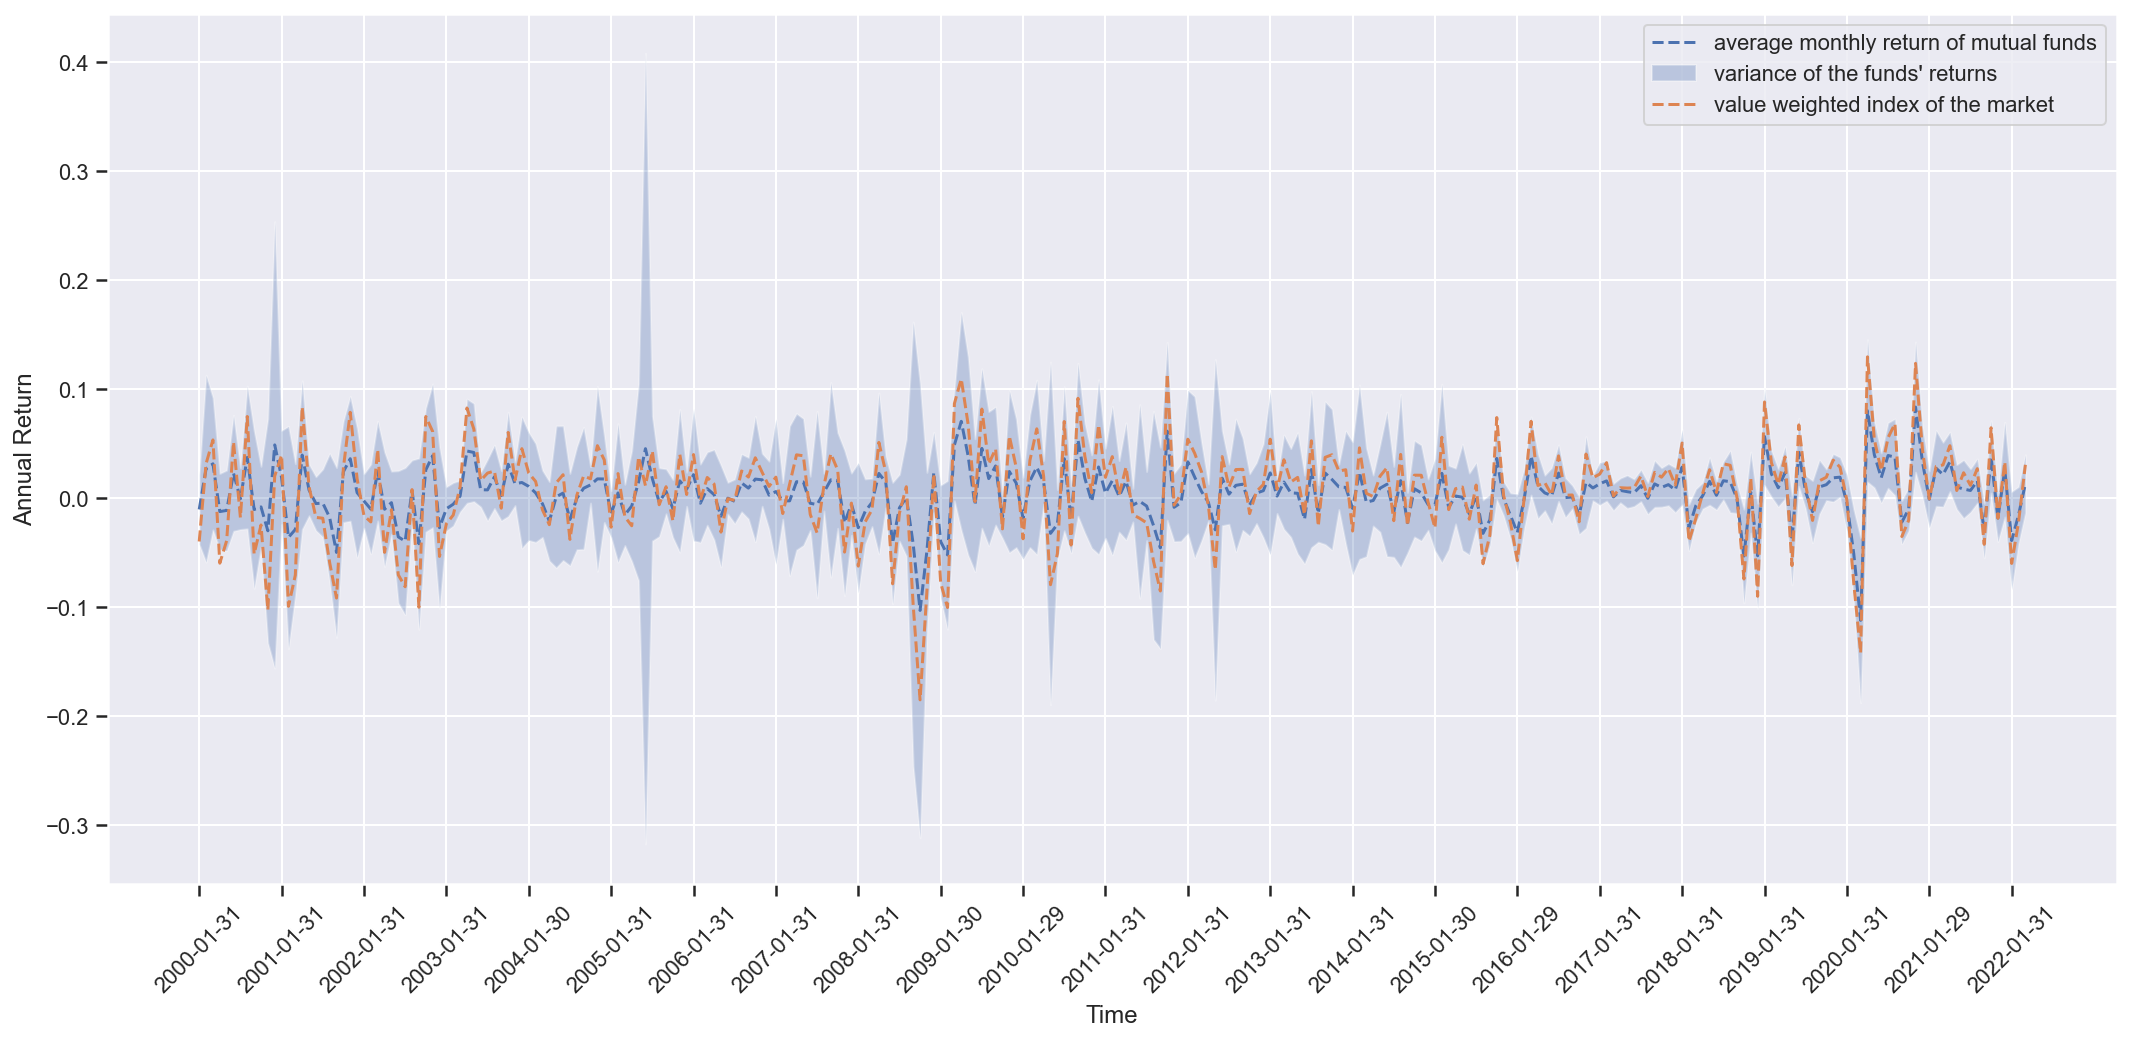

In [24]:
plt.tick_params(left=True,
                bottom=True,
                labelleft=True,
                labelbottom=True)

# Plot the average return of all mutual funds
X=data['caldt'].dt.strftime('%Y-%m-%d')
Y=data['mret']
sns.lineplot(x=X, y=Y, linestyle='--')

# Add variance
lower_bound = data['mret'] + data['mret_sdt']
upper_bound = data['mret'] - data['mret_sdt']

plt.fill_between(X, lower_bound, upper_bound, alpha=.3)

# Average Value Weighted Index - market
X=index_return_query['date'].dt.strftime('%Y-%m-%d')
Y=index_return_query['vwretd']
sns.lineplot(x=X, y=Y, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Annual Return')
plt.xticks(X[::12], rotation=45)

plt.legend(['average monthly return of mutual funds', 'variance of the funds\' returns', 'value weighted index of the market'])
#plt.savefig('data/graphs/annual_return_plots.png', dpi=200)
#plt.savefig('data/graphs/annual_return_plots_with_market.png', dpi=200)
plt.show()

### GET AND PLOT CUMULATIVE RETURNS

In [45]:
# Rename df for better modularity
data = cumulative_data.copy()

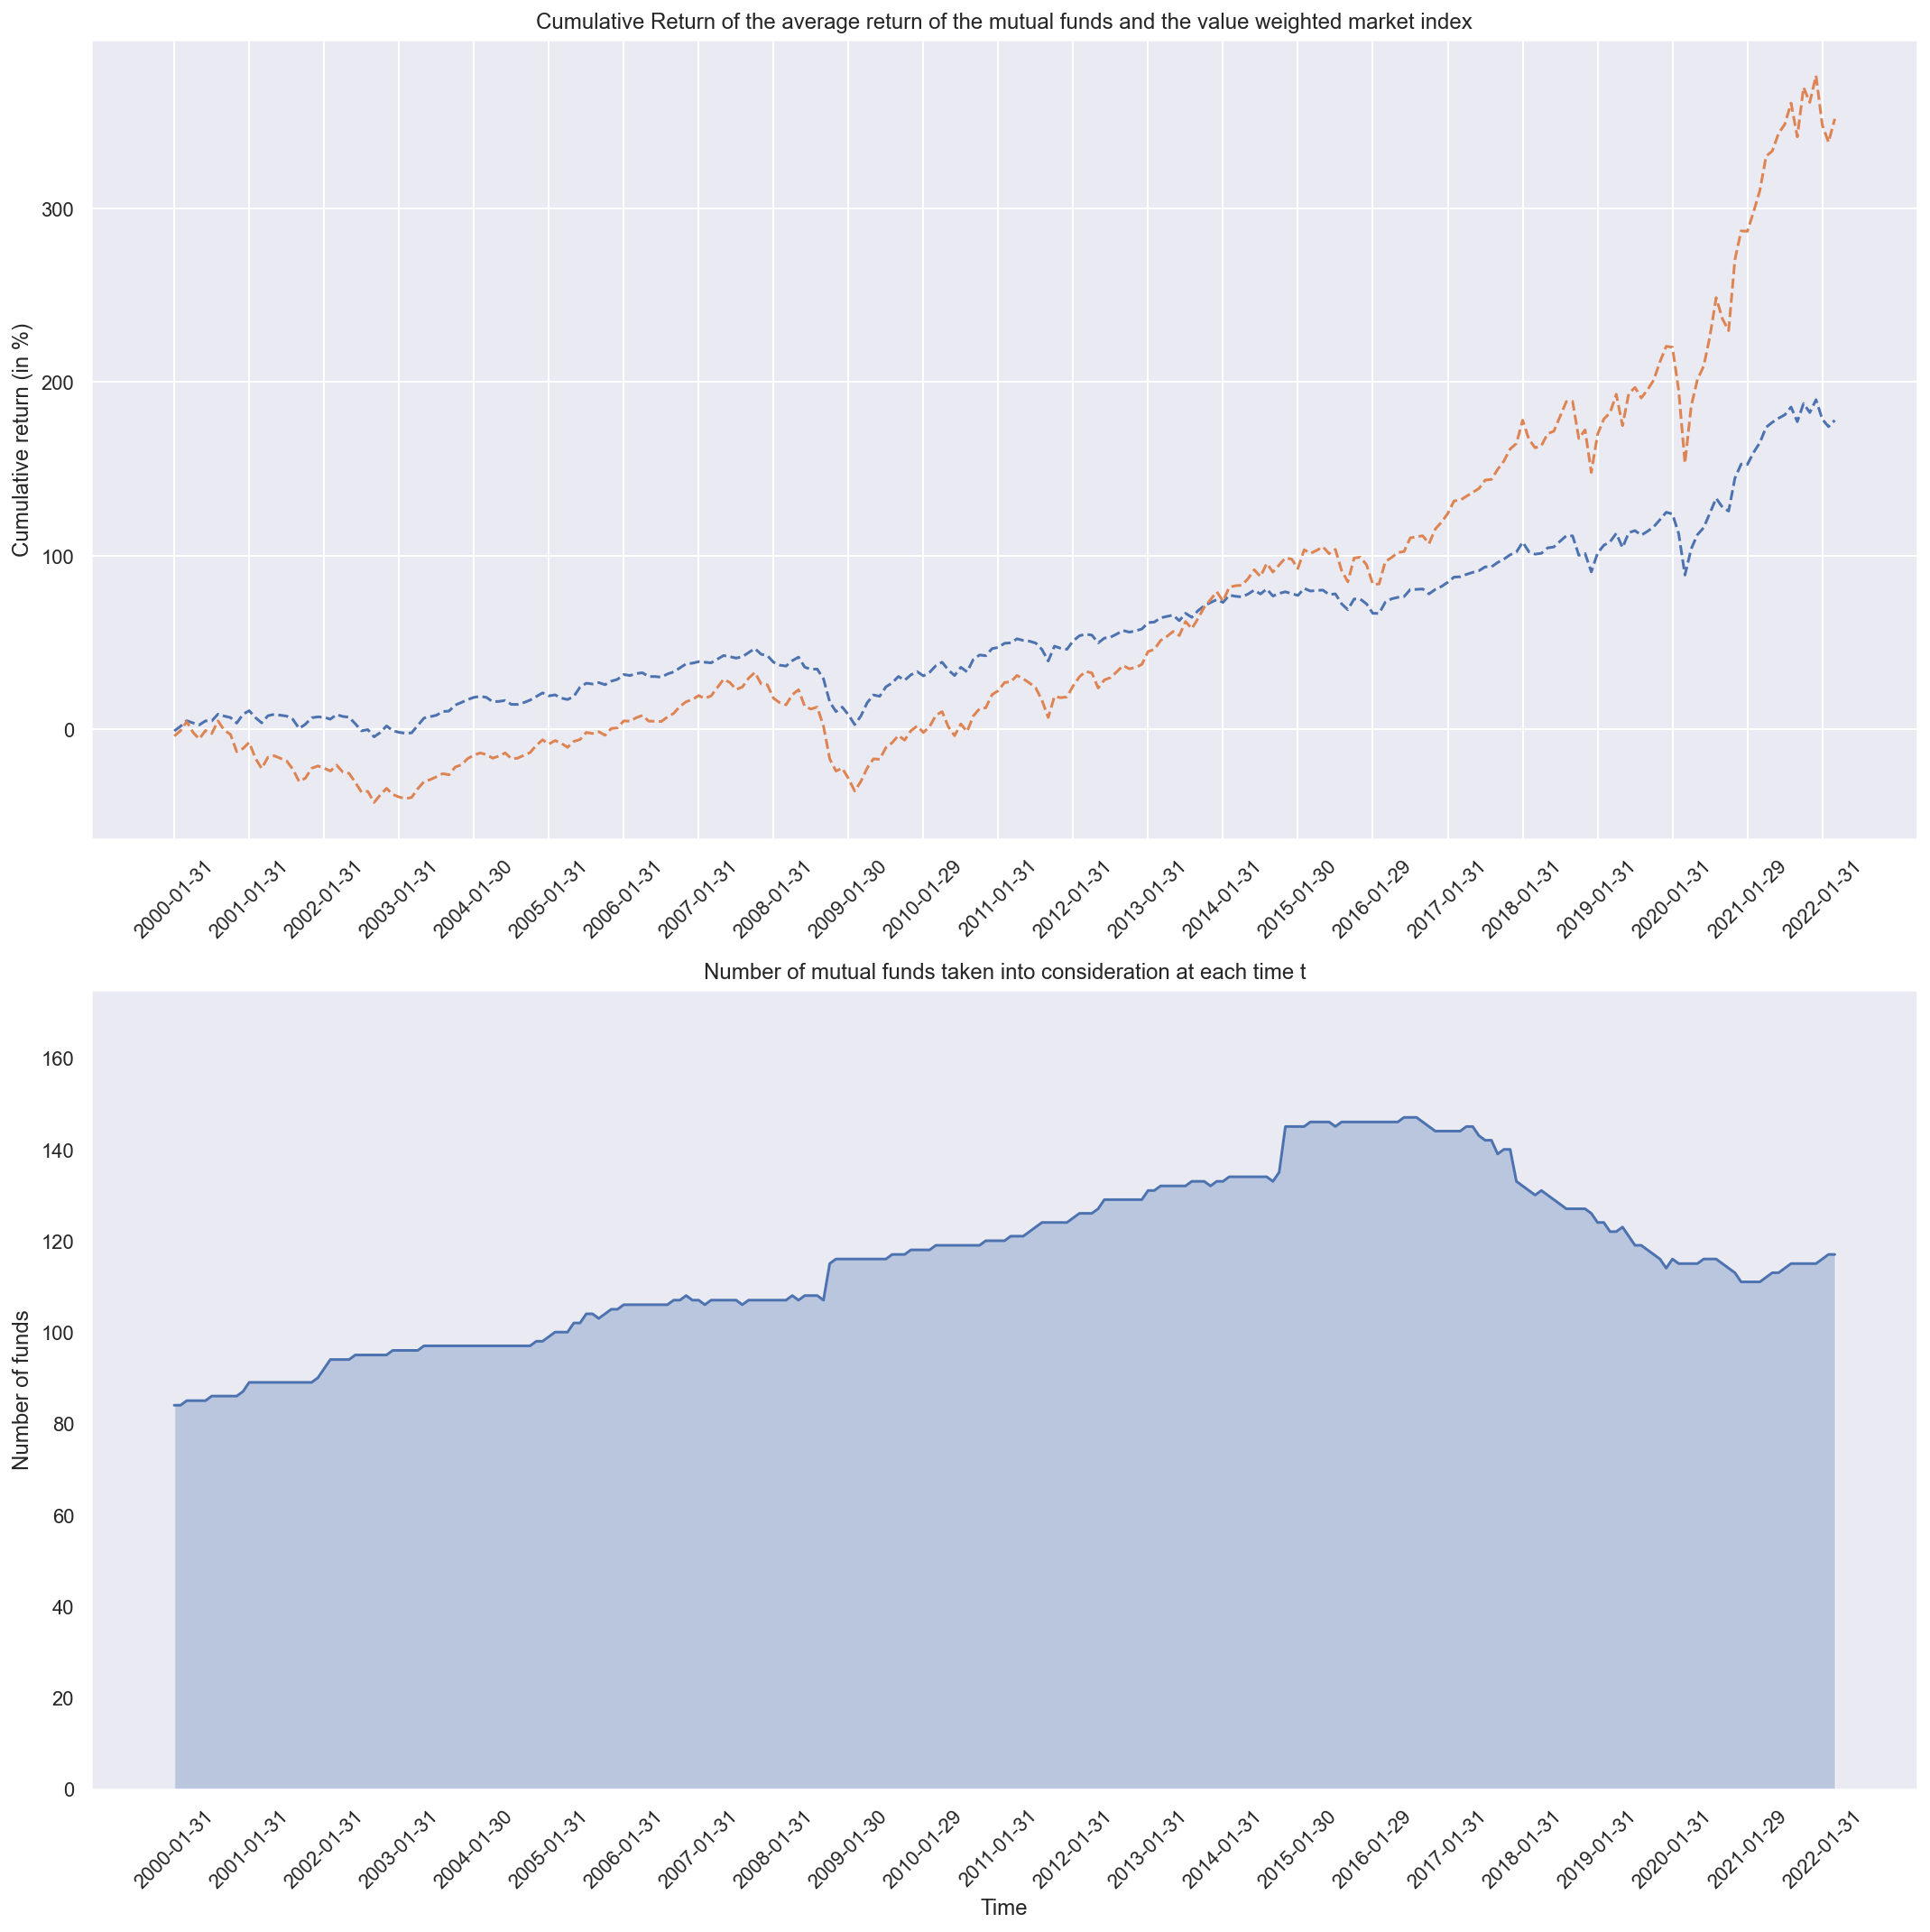

In [46]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 1, 1)

# Plot the cumulative return of all mutual funds
X=data['caldt'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_funds']*100
sns.lineplot(x=X, y=Y, linestyle='--', ax=ax1)

# Cumulative Value Weighted index return - market
X=data['date'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_mkt']*100
sns.lineplot(x=X, y=Y, linestyle='--', ax=ax1)

# Setting for both x-axes
plt.xlabel('')
plt.ylabel('Cumulative return (in %)')
plt.title('Cumulative Return of the average return of the mutual funds and the value weighted market index')
plt.xticks(X[::12], rotation=45)

# Add number of funds per date
ax2 = plt.subplot(2, 1, 2)
X=data['caldt'].dt.strftime('%Y-%m-%d')
ax2.grid(False)
sns.lineplot(x=X, y='count', data=data, ax=ax2)
lower_bound = [0]*len(data['caldt'])
upper_bound = data['count']
plt.fill_between(X, lower_bound, upper_bound, alpha=.3)
ax2.set_ylim([0,175])

# Setting for both x-axes
plt.xlabel('Time')
plt.ylabel('Number of funds')
plt.title('Number of mutual funds taken into consideration at each time t')
plt.xticks(X[::12], rotation=45)


#plt.legend(['Average Performance of mutual funds', 'Value Weighted Market Index'])
#plt.savefig('data/graphs/comparisons_with_vw_market_two_figures.png', dpi=200)
# set the spacing between subplots
#plt.subplots_adjust(hspace=0.4)
fig.tight_layout()
plt.show()

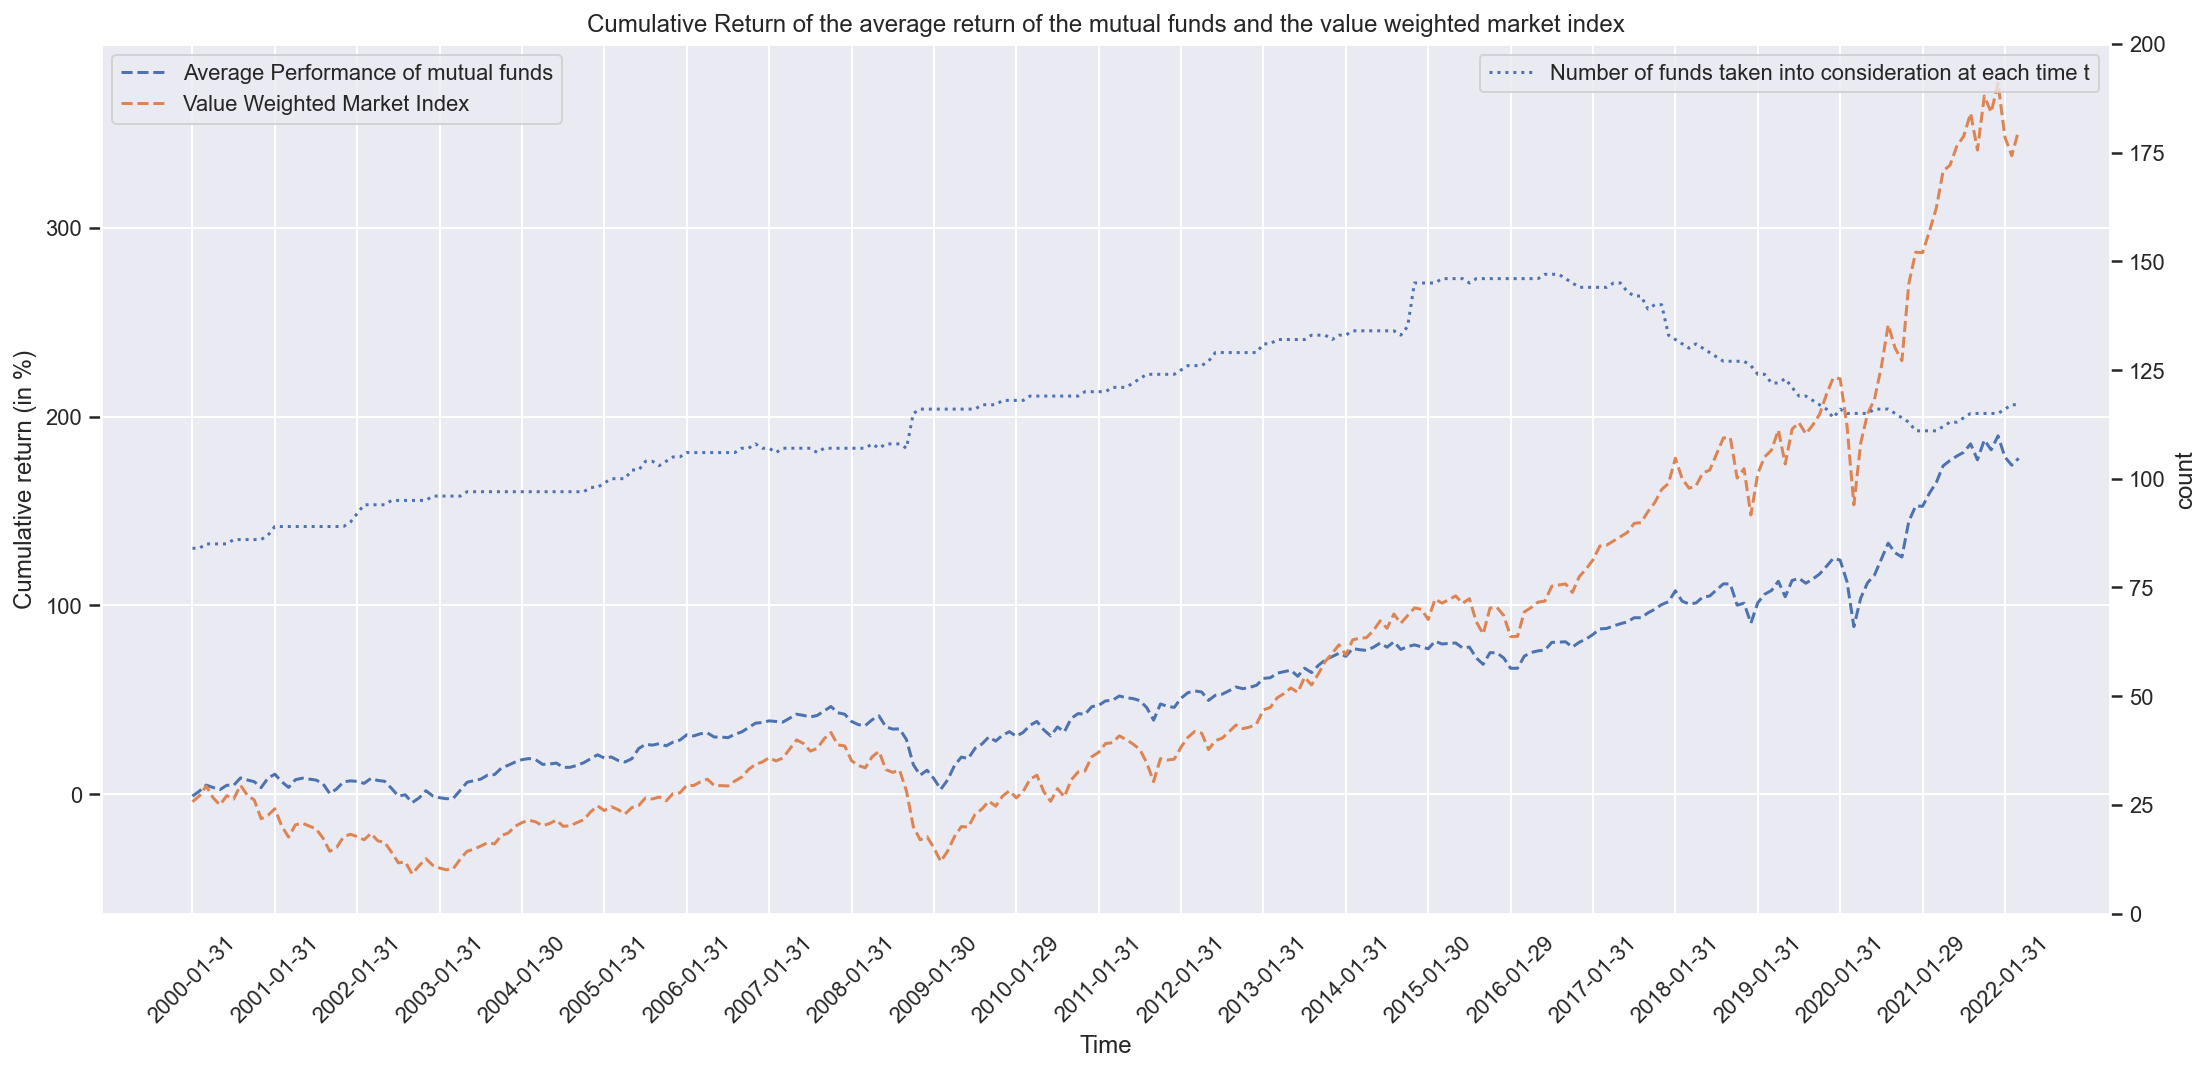

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Plot the cumulative return of all mutual funds
X=data['caldt'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_funds']*100
sns.lineplot(x=X, y=Y, linestyle='--', ax=ax1)

# Cumulative Value Weighted index return - market
X=data['date'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_mkt']*100
sns.lineplot(x=X, y=Y, linestyle='--', ax=ax1)

# Setting for both x-axes
plt.xlabel('Time')
plt.ylabel('Cumulative return (in %)')
plt.title('Cumulative Return of the average return of the mutual funds and the value weighted market index')
plt.legend(['Average Performance of mutual funds', 'Value Weighted Market Index'])
plt.xticks(X[::12], rotation=45)

# Add number of funds per date
ax2 = ax1.twinx()
X=data['caldt'].dt.strftime('%Y-%m-%d')
ax2.grid(False)
sns.lineplot(x=X, y='count', data=data, ax=ax2, linestyle=':')
#lower_bound = [0]*len(data['caldt'])
#upper_bound = data['count']
#plt.fill_between(X, lower_bound, upper_bound, alpha=.3)
ax2.set_ylim([0,200])


plt.legend(['Number of funds taken into consideration at each time t'])
#plt.savefig('data/graphs/comparisons_with_vw_market_one_figure.png', dpi=200)
plt.show()

## FIND VARIABLE NAME IN SCHEMA

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        l= list(filter(lambda x: ('crsp_fundno' in x) and ('cik' in x), db.get_table(library='crsp_q_mutualfunds', table=table, obs=1).keys()))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l)

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        tab_keys = db.get_table(library='crsp_q_mutualfunds', table=table, obs=1).keys()
        l = list(filter(lambda x: 'cik' in x, tab_keys))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l, tab_keys)

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        l= list(filter(lambda x: 'cik' in x, db.get_table(library='crsp', table=table, obs=1).keys()))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l)

## TRY SOME QUERIES

In [ ]:
# Connection to WRDS
import wrds
db = wrds.Connection(wrds_username='etiennebruno')

In [ ]:
db.list_libraries().sort()
db.list_libraries()

In [ ]:
# List the tables of a given library
db.list_tables(library='crsp')

In [ ]:
# Get data
daily = db.get_table(library='crsp', table='fund_summary2', obs=10)

In [ ]:
# Get funds name over a given period
df_funds_map = db.raw_sql('''
        select distinct on (fund_name) fund_name, ticker, ncusip, cusip8
        from crsp.portnomap
        where begdt <= '2020-01-01' --and enddt >= '2022-01-01'
        order by fund_name asc
''')

In [ ]:
# Get funds name over containing some strings of the S&P 500
db.raw_sql('''
        select distinct fund_name
        from crsp.portnomap
        where lower(fund_name::text) LIKE '%%s&p%%'
            and lower(fund_name::text) LIKE '%%500%%'
            --and lower(fund_name::text) LIKE '%%bond%%'
            --and lower(fund_name::text) LIKE '%%national%%'
            --and caldt >= '2010-01-31'
     limit 100
''')

In [ ]:
db.raw_sql('''
        select *
        from crsp.fund_summary2
        where fund_name LIKE '%%FundVantage Trust: Gotham Enhanced S&P 500 Index Fund; Institutional Class Shares%%'
        --and caldt >= '2010-01-31'
''')

In [ ]:
db.raw_sql('''
        select *
        from crsp.portnomap
        where (fund_name::text) LIKE '%%FundVantage Trust: Gotham Enhanced S&P 500 Index Fund; Institutional Class Shares%%'
        --and caldt >= '2010-01-31'
''')

In [ ]:
db.raw_sql('''
        select crsp_fundno, count(mret), max(mret), avg(mret)
        from crsp_q_mutualfunds.monthly_tna_ret_nav
        group by crsp_fundno
        order by count(mret) desc
     limit 10
''')